# Sensitivity to tracers used

Look at how the errors in ub change based on different choices of tracers. 
Continued of the notebook "Sensitivity_coarsening_scales"

In [1]:
import numpy as np
import xarray as xr
from funcs import *
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm
from xgcm import Grid, generate_grid_ds

In [2]:
def flux_reconstruct(tensor, flux, grads, grid, Lcoarse):

    recUflux = -(tensor.sel(i=0, j=0)*grads.dCdx + tensor.sel(i=0, j=1)*grads.dCdy + tensor.sel(i=0, j=2)*grads.dCdz)
    recVflux = -(tensor.sel(i=1, j=0)*grads.dCdx + tensor.sel(i=1, j=1)*grads.dCdy + tensor.sel(i=1, j=2)*grads.dCdz)
    recWflux = -(tensor.sel(i=2, j=0)*grads.dCdx + tensor.sel(i=2, j=1)*grads.dCdy + tensor.sel(i=2, j=2)*grads.dCdz)
    
    errU = np.abs(flux.UpCp - recUflux)/np.abs(flux.UpCp)
    errV = np.abs(flux.VpCp - recVflux)/np.abs(flux.VpCp)
    errW = np.abs(flux.WpCp - recWflux)/np.abs(flux.WpCp)
    
    divUpCp = grid.interp(grid.diff(flux.UpCp, 'X')/Lcoarse, 'X') + \
              grid.interp(grid.diff(flux.VpCp, 'Y', boundary='extend')/Lcoarse, 'Y', boundary='extend') + \
             -grid.interp(grid.diff(flux.WpCp, 'Z', boundary='extend'), 'Z', boundary='extend')/ flux.drF
            
    divUpCphor = grid.interp(grid.diff(flux.UpCp, 'X')/Lcoarse, 'X') + \
              grid.interp(grid.diff(flux.VpCp, 'Y', boundary='extend')/Lcoarse, 'Y', boundary='extend')             
    
    divrecflux = grid.interp(grid.diff(recUflux, 'X')/Lcoarse, 'X') + \
                 grid.interp(grid.diff(recVflux, 'Y', boundary='extend')/Lcoarse, 'Y', boundary='extend') + \
                -grid.interp(grid.diff(recWflux, 'Z', boundary='extend'), 'Z', boundary='extend')/ flux.drF
            
    divrecfluxhor = grid.interp(grid.diff(recUflux, 'X')/Lcoarse, 'X') + \
                 grid.interp(grid.diff(recVflux, 'Y', boundary='extend')/Lcoarse, 'Y', boundary='extend') 
    
    errdiv = np.abs(divUpCp - divrecflux)/np.abs(divUpCp)
    errdivhor = np.abs(divUpCphor - divrecfluxhor)/np.abs(divUpCphor)    
    
    flux_rec=xr.Dataset({'UpCp':recUflux, 'VpCp':recVflux, 'WpCp':recWflux,
                                'errU':errU, 'errV':errV, 'errW':errW, 
                         'divrecflux': divrecflux, 'divUpCp': divUpCp, 'errdiv':errdiv, 'errdivhor':errdivhor})
    
    return flux_rec

In [3]:
Model_Tav = xr.open_dataset('./outputs_ncfiles/Model_Tav.nc')

In [4]:
Lcoarse = 50e3

In [5]:
Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_'+str(int(Lcoarse//1e3))+'km')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_'+str(int(Lcoarse//1e3))+'km')
T_coarse    = xr.open_dataset('./outputs_ncfiles/T_coarse_'+str(int(Lcoarse//1e3))+'km')

In [6]:
list_trac = ['TRAC01', 'TRAC02', 'TRAC03', 'TRAC04', 'TRAC05', 
            'TRAC06', 'TRAC07', 'TRAC08', 'TRAC09', 'TRAC10', 
            'TRAC11', 'TRAC12', 'TRAC13', 'TRAC14', 'TRAC15', 
            'TRAC16', 'TRAC17', 'TRAC18', 'TRAC19', 'TRAC20']

In [7]:
[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse, list_trac)
[dCdx, dCdy, dCdz]= get_grad_arrays(Trac_coarse, list_trac)

# Tracers for 3D setup (with ridge in the middle.)
$$C1 = yg/Lx$$
$$C2 = (-zg)/H$$
$$C3 = cos(2*np.pi*xg/Lx)$$
$$C4 = sin(2*np.pi*xg/Lx)$$
$$C5 = sin(4*np.pi*xg/Lx)$$
$$C6 = sin(np.pi*yg/Lx)$$
$$C7 = cos(2*np.pi*yg/Lx)$$
$$C8 = sin(2*np.pi*yg/Lx)$$
$$C9 = cos(np.pi*zg/H)$$
$$C10 = sin(np.pi*zg/H)$$

In [8]:
tfast1 = [1,3,5] # 1 of each
tfast2 = [1,3,5,7,11,17] # 2 of each
tfast3 = [1,3,5,7,9,11,13,17,19] # 3 of each
tfast4 = [1,3,5,7,9,11,13,15,17,19] # all
tsets = {'3':tfast1, '6':tfast2, '9':tfast3, '10':tfast4}


In [9]:
fluxT = xr.Dataset({'UpCp':T_coarse.UpTp, 'VpCp':T_coarse.VpTp, 'WpCp':T_coarse.WpTp})
gradT = xr.Dataset({'dCdx':T_coarse.T_X, 'dCdy':T_coarse.T_Y, 'dCdz':T_coarse.T_Z})

# define a grid for taking gradients on coarse grid
grid_ds = xr.Dataset()
grid_ds['TRAC01'] = Trac_coarse['TRAC01']
grid_ds['wVeltave'] = Model_Tav['wVeltave']
grid_ds = grid_ds.drop(['wVeltave','XC','YC']).isel(XC=0, YC=0)
ds = generate_grid_ds(grid_ds, {'X': 'XCcoarse', 'Y':'YCcoarse'})
grid = Grid(ds, periodic='X')

In [10]:
Ktensor_corr ={}

In [11]:
for key in tsets.keys():
# Calculate the tensor
    tfast = tsets[key]
    tslow = [x+1 for x in tfast]
    Ktensor_fast = xr.apply_ufunc(calc_tensor, 
                           UpCp.sel(tracer_num=tfast),
                           VpCp.sel(tracer_num=tfast),
                           WpCp.sel(tracer_num=tfast),
                           dCdx.sel(tracer_num=tfast),
                           dCdy.sel(tracer_num=tfast),
                           dCdz.sel(tracer_num=tfast),
                           input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                           vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                           output_dtypes=['float32'], output_sizes={'i':3,'j':3})

    Ktensor_fast.load() # need to load because we will take transpose and a


    Ktensor_slow = xr.apply_ufunc(calc_tensor, 
                           UpCp.sel(tracer_num=tslow),
                           VpCp.sel(tracer_num=tslow),
                           WpCp.sel(tracer_num=tslow),
                           dCdx.sel(tracer_num=tslow),
                           dCdy.sel(tracer_num=tslow),
                           dCdz.sel(tracer_num=tslow),
                           input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                           vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                           output_dtypes=['float32'], output_sizes={'i':3,'j':3})

    Ktensor_slow.load() # need to load because we will take transpose and a
    
    lam1 = 1/31104000.
    lam2 = 1/186624000.

    Ktensor_corr[key] = (lam2*Ktensor_fast - lam1*Ktensor_slow)/(lam2 - lam1)

In [12]:
colors = ['Red', 'Blue', 'Green','Purple']

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/dbalwada/.conda/envs/pangeo/lib/py

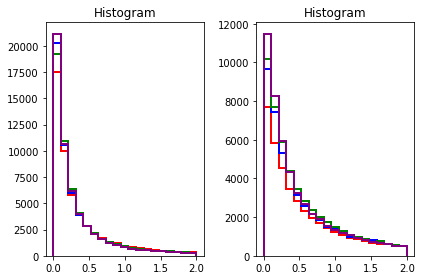

In [71]:
for key in tsets.keys():
    frb_corr = flux_reconstruct(Ktensor_corr[key], fluxT, gradT, grid, Lcoarse)
    
    plt.subplot(121)
    [_,_,_] = frb_corr.errU.where(Trac_coarse.hFacCcoarse==1.).plot.hist(bins=bins,
                         histtype='step',edgecolor= colors[int(key)-1], linewidth=2, fill=False)
    plt.subplot(122)
    [_,_,_] = frb_corr.errdiv.where(Trac_coarse.hFacCcoarse==1.).plot.hist(bins=bins,
                         histtype='step',edgecolor= colors[int(key)-1], linewidth=2, fill=False)
plt.tight_layout()

In [13]:
params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

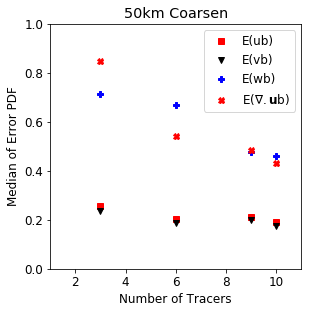

In [102]:
for key in tsets.keys():
    frb_corr = flux_reconstruct(Ktensor_corr[key], fluxT, gradT, grid, Lcoarse)
    if key=='3':
        plt.plot(int(key), frb_corr.errU.where(Trac_coarse.hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']),
                 'rs', label='E(ub)')
        plt.plot(int(key), frb_corr.errV.where(Trac_coarse.hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'kv', label='E(vb)')
        plt.plot(int(key), frb_corr.errW.where(Trac_coarse.hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bP', label='E(wb)')

        plt.plot(int(key), frb_corr.errdiv.where(Trac_coarse.hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'rX', label=r'E($\nabla.\mathbf{u}$b)')
        #plt.plot(int(key), frb_corr.errdivhor.where(Trac_coarse.hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bx', label=r'E($\nabla_H.\mathbf{u}_H$b)')
    else:
        plt.plot(int(key), frb_corr.errU.where(Trac_coarse.hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']),
                 'rs')
        plt.plot(int(key), frb_corr.errV.where(Trac_coarse.hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'kv')
        plt.plot(int(key), frb_corr.errW.where(Trac_coarse.hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bP')

        plt.plot(int(key), frb_corr.errdiv.where(Trac_coarse.hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'rX')
        #plt.plot(int(key), frb_corr.errdivhor.where(Trac_coarse.hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bx')
    
plt.legend()    
plt.xlabel('Number of Tracers')
plt.ylabel('Median of Error PDF')
plt.title('50km Coarsen')
plt.xlim([1,11])
plt.ylim([0,1])
plt.savefig('fig2a.pdf', dpi=200,bbox_inches='tight')


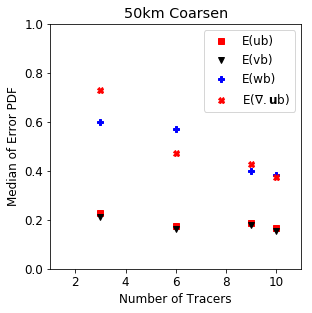

In [14]:
for key in tsets.keys():
    frb_corr = flux_reconstruct(Ktensor_corr[key], fluxT, gradT, grid, Lcoarse)
    if key=='3':
        plt.plot(int(key), frb_corr.errU.where(Trac_coarse.hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']),
                 'rs', label='E(ub)')
        plt.plot(int(key), frb_corr.errV.where(Trac_coarse.hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']), 'kv', label='E(vb)')
        plt.plot(int(key), frb_corr.errW.where(Trac_coarse.hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']), 'bP', label='E(wb)')

        plt.plot(int(key), frb_corr.errdiv.where(Trac_coarse.hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']), 'rX', label=r'E($\nabla.\mathbf{u}$b)')
        #plt.plot(int(key), frb_corr.errdivhor.where(Trac_coarse.hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bx', label=r'E($\nabla_H.\mathbf{u}_H$b)')
    else:
        plt.plot(int(key), frb_corr.errU.where(Trac_coarse.hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']),
                 'rs')
        plt.plot(int(key), frb_corr.errV.where(Trac_coarse.hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']), 'kv')
        plt.plot(int(key), frb_corr.errW.where(Trac_coarse.hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']), 'bP')

        plt.plot(int(key), frb_corr.errdiv.where(Trac_coarse.hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']), 'rX')
        #plt.plot(int(key), frb_corr.errdivhor.where(Trac_coarse.hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bx')
    
plt.legend()    
plt.xlabel('Number of Tracers')
plt.ylabel('Median of Error PDF')
plt.title('50km Coarsen')
plt.xlim([1,11])
plt.ylim([0,1])
plt.savefig('fig2a.pdf', dpi=200,bbox_inches='tight')
